In [1]:
import torch
import wandb
from components import NeuralProcess
from matplotlib import pyplot as plt
from metalearning_benchmarks.sinusoid1d_benchmark import Sinusoid1D
from train_val import train_and_validate
from utils import DataModule, MetaLearningDataset, split_context_target, Config

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [3]:
config = Config(
    task="sinusoid1d",
    n_task=4096,
    n_datapoints_per_task=128,
    output_noise=0.01,
    seed_task=1235, 
    seed_x=123, 
    seed_noise=1237,
    x_dim=1,
    y_dim=1,
    r_dim=32,
    z_dim=32,
    h_dim=32,
    split=(0.8, 0.2),
    batch_size=128,
    num_epochs=100,
    learning_rate=0.005,
)

In [4]:
wandb.init(project="neural-process", config=config.asdict())

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [5]:
benchmark = Sinusoid1D(
    n_task=config.n_task,
    n_datapoints_per_task=config.n_datapoints_per_task,
    output_noise=config.output_noise,
    seed_task=config.seed_task, 
    seed_x=config.seed_x, 
    seed_noise=config.seed_noise,
)

dataset = MetaLearningDataset(benchmark)

data_module = DataModule(
    batch_size=config.batch_size,
    dataset_and_split=(dataset, config.split),
)

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 208782.41it/s]


In [6]:
model = NeuralProcess(
    x_dim=config.x_dim, 
    y_dim=config.y_dim, 
    r_dim=config.r_dim, 
    z_dim=config.z_dim, 
    h_dim=config.h_dim, 
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

In [7]:
avg_train_neg_log_likes = []
avg_train_kl_divs = []

avg_val_neg_log_likes = []
avg_val_kl_divs = []

In [8]:
losses = train_and_validate(
    model=model,
    data_module=data_module,
    num_epochs=config.num_epochs,
    device=device,
    optimizer=optimizer,
)

avg_train_neg_log_likes.extend(losses[0])
avg_train_kl_divs.extend(losses[1])

avg_val_neg_log_likes.extend(losses[2])
avg_val_kl_divs.extend(losses[3])

  0%|          | 0/26 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
100%|██████████| 7/7 [00:00<00:00, 17.01it/s, epoch=99, kl_div=0.889, loss=-15.7, recon_loss=-16.6]


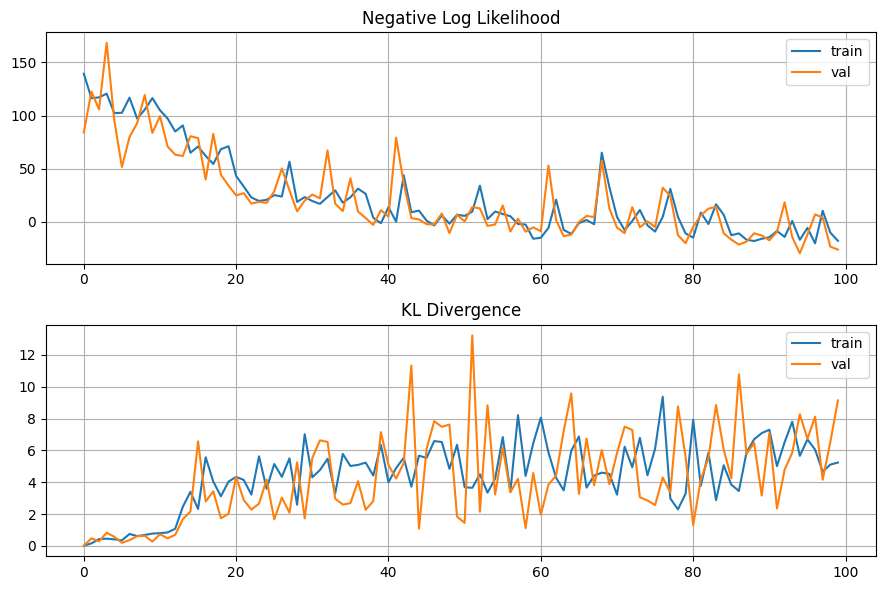

In [9]:
_, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(avg_train_neg_log_likes, label="train")
ax[0].plot(avg_val_neg_log_likes, label="val")
ax[0].set_title("Negative Log Likelihood")
ax[0].grid()
ax[0].legend()

ax[1].plot(avg_train_kl_divs, label="train")
ax[1].plot(avg_val_kl_divs, label="val")
ax[1].set_title("KL Divergence")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

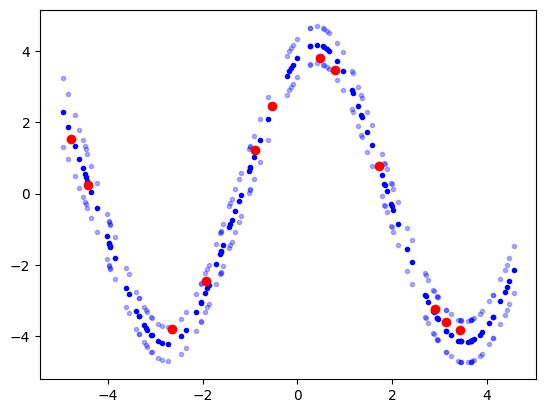

In [18]:
gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)

x_data, y_data = next(iter(gen_dataloader))
x_data, y_data = x_data.to(device), y_data.to(device)

factor = 0.1
x_context, y_context, x_target, y_target = split_context_target(x_data, y_data, factor, random=False)

n_samples = 1

mus, logvars, _, _ = model.sample(x_context, y_context, x_target, n_samples)

for i in range(n_samples):
    plt.scatter(x_target.cpu().detach().numpy(), mus[i].cpu().detach().numpy(), marker=".", c="blue")
    plt.scatter(
        x_target.cpu().detach().numpy(), 
        (mus[i] - 2*torch.exp(0.5 * logvars[i])).cpu().detach().numpy(), 
        marker=".", 
        c="blue",
        alpha=0.3,
    )
    plt.scatter(
        x_target.cpu().detach().numpy(), 
        (mus[i] + 2*torch.exp(0.5 * logvars[i])).cpu().detach().numpy(), 
        marker=".", 
        c="blue",
        alpha=0.3,
    )

plt.scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="o", c="red")

plt.show()

In [19]:
torch.save(model.state_dict(), "../../models/astral-wave-4.pt")